# Library

In [4]:
%matplotlib inline
import numpy as np
import cv2
import skimage.data as data
from skimage.morphology import extrema
from skimage.morphology import watershed as skwater
import skimage.segmentation as seg
import matplotlib.pyplot as plt
import pydicom

# Function

In [5]:
def ShowImage(title,img,ctype):
  plt.figure(figsize=(9, 9))
  if ctype=='gray':
    plt.imshow(img,cmap='gray')
  elif ctype=='rgb':
    plt.imshow(img)
  else:
    raise Exception("Unknown colour type")
  plt.axis('off')
  plt.title(title)
  plt.show()

def masking(image):
    foreground_value = 255
    mask = np.uint8(image == foreground_value)

    labels, stats = cv2.connectedComponentsWithStats(mask, 4)[1:3]
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    image = np.zeros_like(image)
    image[labels == largest_label] = foreground_value
    ShowImage('masking',image,'rgb')

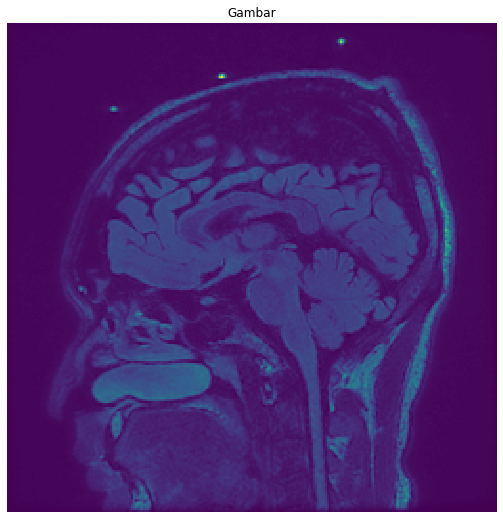

In [6]:
basepath ="../dicom/"
d = pydicom.read_file(basepath + "Z108")
file = np.array(d.pixel_array)
img = file
ShowImage('Gambar',img,'rgb')

In [7]:
img_2d = img.astype(float)
img_2d_scaled = (np.maximum(img_2d,0) / img_2d.max()) * 255.0
img_2d_scaled = np.uint8(img_2d_scaled)
hasil = img_2d_scaled

# Gaussian

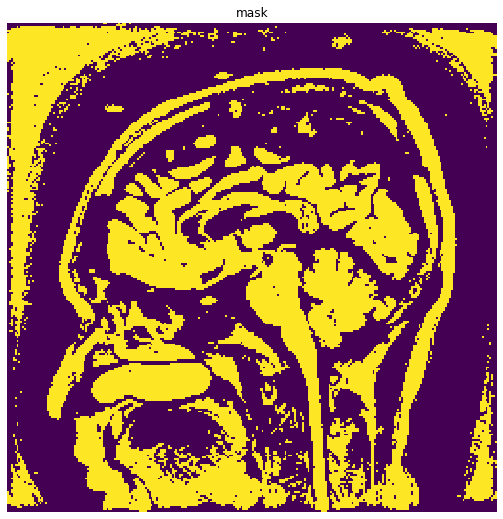

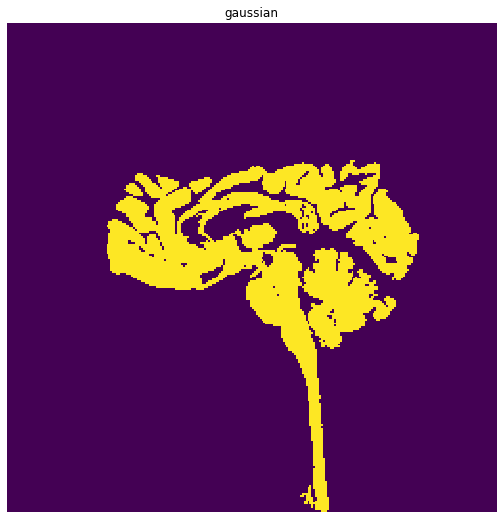

In [11]:
gaussian = cv2.adaptiveThreshold(hasil,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,115, 1)

foreground_value = 255
mask_gaussian = np.uint8(gaussian == foreground_value)
ShowImage('mask',mask_gaussian,'rgb')

labels, stats = cv2.connectedComponentsWithStats(mask_gaussian, 4)[1:3]
largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
gauss = np.zeros_like(gaussian)
gauss[labels == largest_label] = foreground_value
ShowImage('gaussian',gauss,'rgb')

# Erosien from gauss

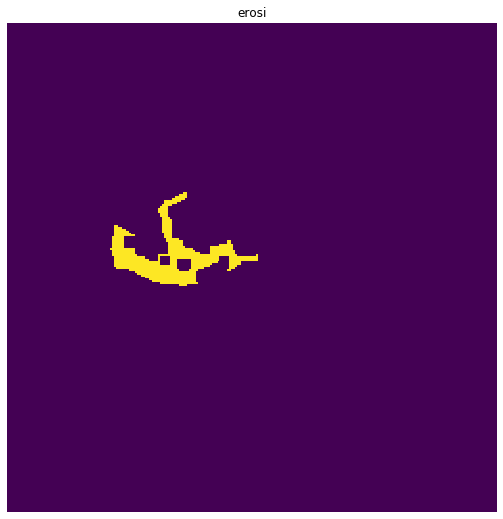

In [12]:
kernel = np.ones((5, 5), np.uint8)
erosion = cv2.erode(gauss,kernel,iterations = 1)

foreground_value = 255
mask_erosion = np.uint8(erosion >= foreground_value)
# ShowImage('mask',mask,'rgb')

labels, stats = cv2.connectedComponentsWithStats(mask_erosion, 4)[1:3]
largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
erosi = np.zeros_like(erosion)
erosi[labels == largest_label] = foreground_value
ShowImage('erosi',erosi,'rgb')

# opening from erosion

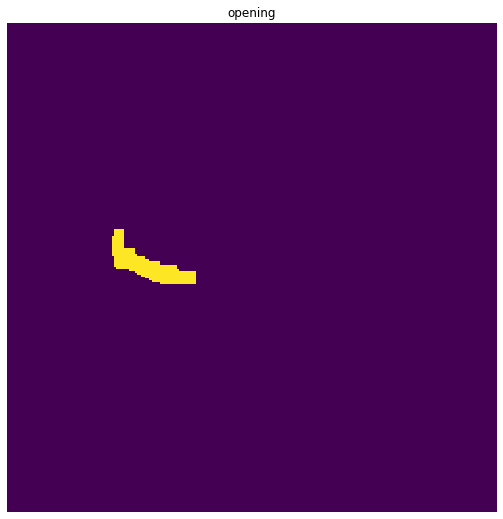

In [13]:
bentuk = np.ones((5, 5), np.uint8)
opening = cv2.morphologyEx(erosi, cv2.MORPH_OPEN, bentuk)
# ShowImage('opening',opening,'rgb')

foreground_value = 255
mask_opening = np.uint8(opening >= foreground_value)
# ShowImage('mask',mask,'rgb')

labels, stats = cv2.connectedComponentsWithStats(mask_opening, 4)[1:3]
largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
buka = np.zeros_like(opening)
buka[labels == largest_label] = foreground_value
ShowImage('opening',buka,'rgb')



# Closing from erosion

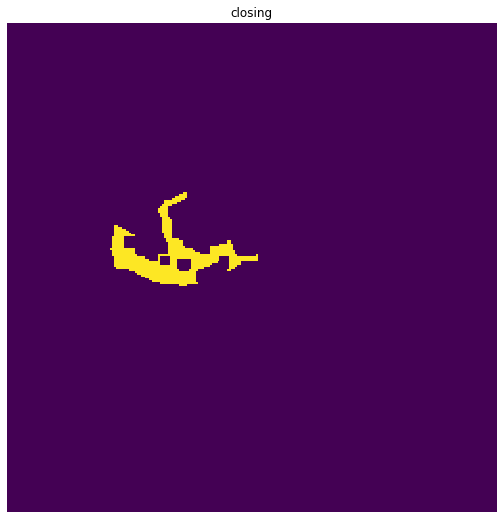

In [14]:
kernel = np.ones((5, 5), np.uint8)
closing = cv2.morphologyEx(erosi, cv2.MORPH_CLOSE, kernel)
# ShowImage('closing',closing,'rgb')

foreground_value = 255
mask_closing = np.uint8(closing >= foreground_value)
# ShowImage('mask',mask,'rgb')

labels, stats = cv2.connectedComponentsWithStats(mask_closing, 4)[1:3]
largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
close = np.zeros_like(closing)
close[labels == largest_label] = foreground_value
ShowImage('closing',close,'rgb')

# Dilation from opening

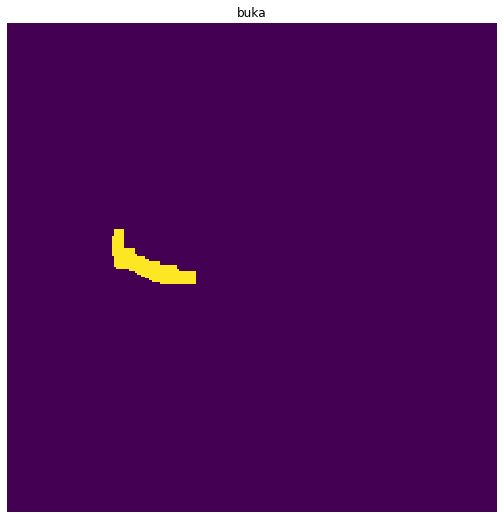

In [15]:
shape = np.ones((5, 5), np.uint8)
dilation = cv2.dilate(opening,shape,iterations = 1)

foreground_value = 255
mask_dilation = np.uint8(opening >= foreground_value)
# ShowImage('mask',mask,'rgb')

labels, stats = cv2.connectedComponentsWithStats(mask_dilation, 4)[1:3]
largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
buka = np.zeros_like(opening)
buka[labels == largest_label] = foreground_value
ShowImage('buka',buka,'rgb')

# Dilation from closing

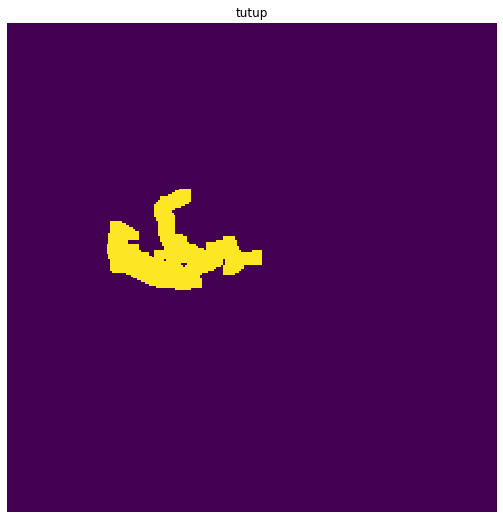

In [16]:
bentukan = np.ones((5, 5), np.uint8)
dilasi = cv2.dilate(closing,bentukan,iterations = 1)

foreground_value = 255
mask_dilasi = np.uint8(dilasi >= foreground_value)
# ShowImage('mask',mask,'rgb')

labels, stats = cv2.connectedComponentsWithStats(mask_dilasi, 4)[1:3]
largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
tutup = np.zeros_like(dilasi)
tutup[labels == largest_label] = foreground_value
ShowImage('tutup',tutup,'rgb')


# Skull Striping

In [17]:
img_2d = file.astype(float)
img_2d_scaled = (np.maximum(img_2d,0) / img_2d.max()) * 255.0
img_2d_scaled = np.uint8(img_2d_scaled)
hasil = img_2d_scaled

#Skull Stripping
skull_stripped_image = cv2.bitwise_and(
    hasil, hasil, mask = tutup)
brain_pixels = skull_stripped_image[tutup == foreground_value]
print (brain_pixels, 'Brain Pixels')

# Adapting the data to K-means
kmeans_input = np.float32(brain_pixels.reshape(
    brain_pixels.shape[0], brain_pixels.ndim))
print(kmeans_input, 'Kmeans Input')

# K-means parameters
epsilon = 0.01
number_of_iterations = 50
number_of_clusters = 4
number_of_repetition = 10
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,
            number_of_iterations, epsilon)
flags = cv2.KMEANS_RANDOM_CENTERS
print(criteria, 'criteria Paramaters')

# K-means segmentation
_, labels, centers = cv2.kmeans(
    kmeans_input, number_of_clusters, None, criteria,
    number_of_repetition, flags)
print(labels.shape, 'K-means segmentation')

# Adapting the labels
labels = labels.flatten('F')
for x in range(number_of_clusters):
    labels[labels == x] = centers[x]

[58 77 75 ... 45 42 42] Brain Pixels
[[58.]
 [77.]
 [75.]
 ...
 [45.]
 [42.]
 [42.]] Kmeans Input
(3, 50, 0.01) criteria Paramaters
(1819, 1) K-means segmentation


# Segmented image

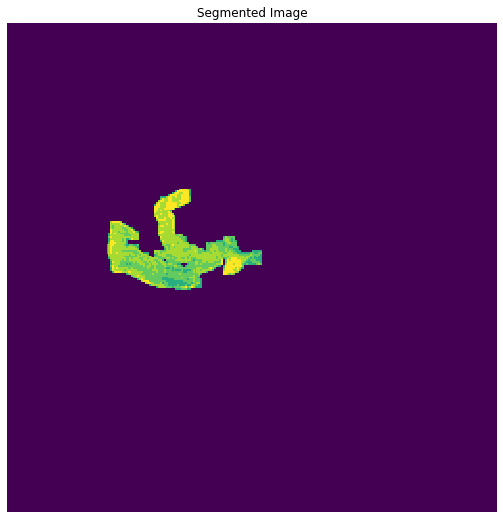

In [18]:
segmented_image = np.zeros_like(tutup)
segmented_image[tutup == foreground_value] = labels
ShowImage('Segmented Image',segmented_image,'rgb')